In [1]:
# !pip install import-ipynb

In [2]:
import import_ipynb
from Utils import *

importing Jupyter notebook from Utils.ipynb


In this section I estimated: 
1. Interest rates: https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield
2. Moody's Spread: https://fred.stlouisfed.org/series/BAA10Y
I estimated data from October 2000 to end of 2000 using train data from beginning of 2000 till end of September 2000.

The algorithm I used for the predcition is regression random forest.
I estimated interest rates of different periods: [3 Month, 1 Year, 5 Years, 10 Years, 30 Years] (and the spread)
using the data from the other time series. Meaning that, for example, in order to estimate the 3 month interest I used data from 1 year interest and vice versa.

Furthermore, in 2 of my estimations I added statistics such as the mean and standart variation of the series.
I used random forest with 3 different set of features, all of them have the data of the other time series and the last 2 features sets has the statistics on different period of time. At the second feature set I normalized the data as well.

I compared the results of the 3 feature set using mean squared error metric and tried the one which yield the best results on the test set.

# Prepare data and util functions

In [3]:
PERIODS = ['3 Mo', '1 Yr', '5 Yr', '10 Yr', '30 Yr']
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = VAL_START_DATE =  '2000-08-01'
VAL_END_DATE = TEST_START_DATE =  '2000-10-01'
TEST_END_DATE =  '2001-01-10'

In [4]:
data_df = create_data_df(use='dataset', start_date=TRAIN_START_DATE, end_date=TEST_END_DATE) 

I chose to estimate the interest (or spread) rate in 7 (business) days.
For each interest rate we need to assign a label, which will be the value of the interest in 7 (business) days.

# Prepare labels

In [5]:
PERIODS = PERIODS + ['BAA10Y']
period_labels = []
for period in PERIODS:
    period_labels.append('{period}_label'.format(period=period))

In [6]:
BUSINESS_DAYS = 7
for idx, period in enumerate(PERIODS):
    data_df[period_labels[idx]] = data_df.shift(periods=-BUSINESS_DAYS)[period]
data_df = data_df.dropna()

# Split data

For each interest rate we will build predictor. The predictor's features will be the different interest rates and the spread


In [7]:
train_df = data_df.loc[TRAIN_START_DATE:TRAIN_END_DATE]
val_df = data_df.loc[VAL_START_DATE:VAL_END_DATE]
test_df = data_df.loc[TEST_START_DATE:TEST_END_DATE]

In [8]:
results_df = pd.DataFrame(index=PERIODS)

# Feature set #1

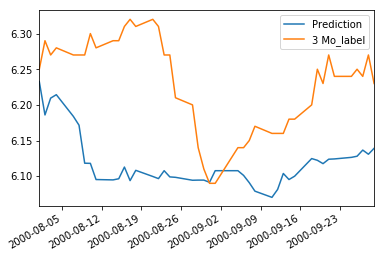

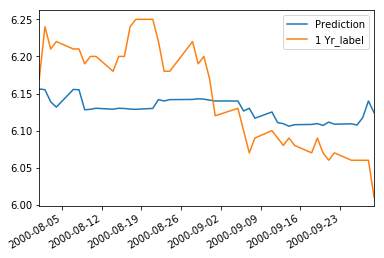

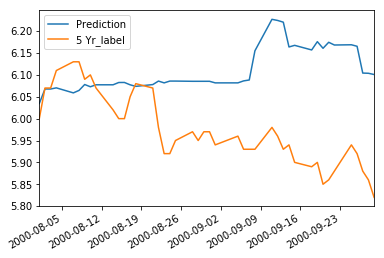

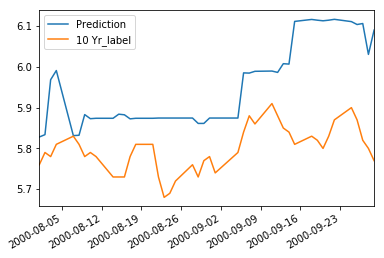

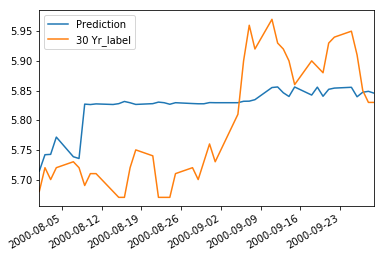

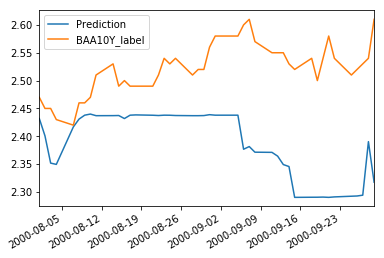

In [9]:
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd 

results = []
for idx, interest_to_predict in enumerate(period_labels):
    regr = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
    regr.fit(train_df[PERIODS], train_df[interest_to_predict])
    y_predict = pd.DataFrame(data=regr.predict(val_df[PERIODS]).reshape(-1,1), columns=['Prediction'])
    y_true = val_df[interest_to_predict]
    y_predict.index = y_true.index
    prediction_df = pd.concat([y_predict, y_true], axis=1)
    prediction_df.plot()
    results.append(mean_squared_error(y_predict, y_true))

results_df = add_column_to_df(results_df, 'Feature_set_1', results) 

The predictions does not look correlated to the actual data for all time series

# Feature set #2

# Normalize

In [10]:
from sklearn import preprocessing

train_df_scaled = pd.DataFrame(data=preprocessing.scale(train_df), columns=train_df.columns) 
val_df_scaled = pd.DataFrame(data=preprocessing.scale(val_df), columns=val_df.columns) 

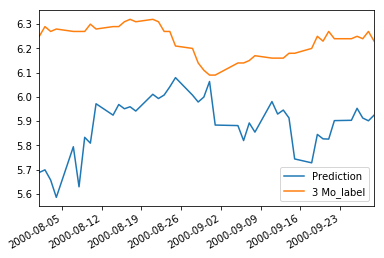

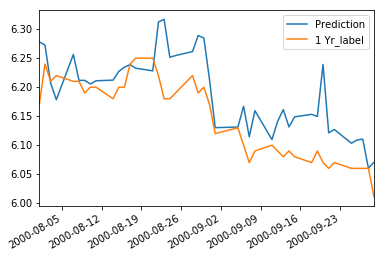

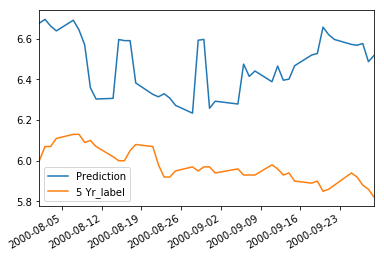

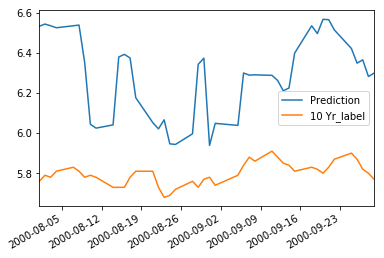

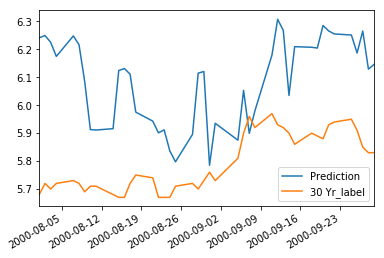

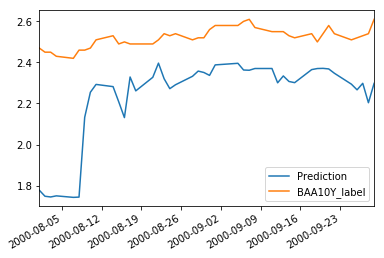

In [11]:
mean = train_df.mean()
std = train_df.std()

results = list()
for period_idx, interest_to_predict in enumerate(period_labels):
    regr2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
    regr2.fit(train_df_scaled[PERIODS], train_df_scaled[interest_to_predict])
    y_predict = pd.DataFrame(data=regr2.predict(val_df_scaled[PERIODS]).reshape(-1,1), columns=['Prediction'])
    y_predict = y_predict*std[period_idx]+mean[period_idx]
    y_true = val_df[interest_to_predict]
    y_predict.index = y_true.index
    prediction_df = pd.concat([y_predict, y_true], axis=1)
    prediction_df.plot()
    results.append(mean_squared_error(y_predict, y_true))

results_df = add_column_to_df(results_df, 'Feature_set_2', results)

The predictions does not look good for the interest rates since for many time series it have spikes that
might lead a decision maker to take a inaccurate decision since the actual data is behave differently.

The spread prediction might mislead a decision maker at the time period until 12.08.2000 (at validation set time)
but the prediction looks correlated to the actual data.

# Feature set #3

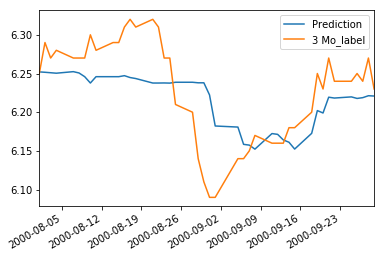

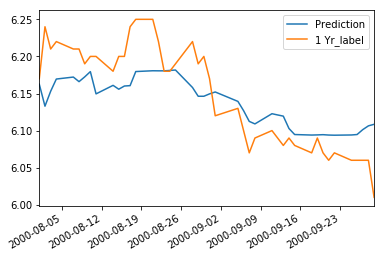

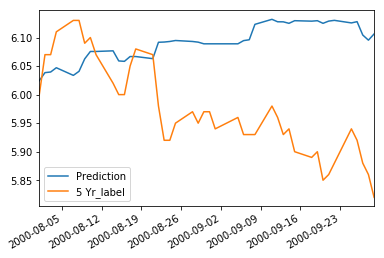

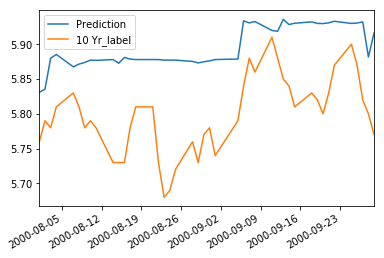

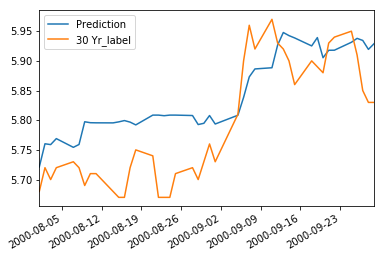

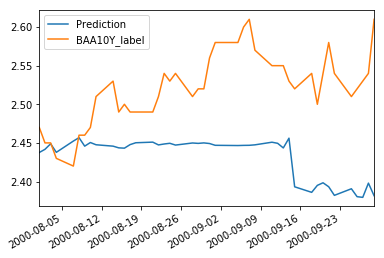

In [12]:
import warnings
warnings.filterwarnings('ignore')

features = PERIODS + ['mean', 'std']
results = []
for interest_to_predict in period_labels:
    rolling_data_df = data_df
    rolling_data_df['mean'] = data_df[interest_to_predict].rolling(window=BUSINESS_DAYS).mean()
    rolling_data_df['std'] = data_df[interest_to_predict].rolling(window=BUSINESS_DAYS).std()
    rolling_train_df = rolling_data_df.loc[TRAIN_START_DATE:TRAIN_END_DATE]
    rolling_val_df = rolling_data_df.loc[VAL_START_DATE:VAL_END_DATE]
    rolling_train_df = rolling_train_df.dropna()
    rolling_val_df = rolling_val_df.dropna()
    regr = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
    regr.fit(rolling_train_df[features], rolling_train_df[interest_to_predict])
    y_predict = pd.DataFrame(data=regr.predict(rolling_val_df[features]).reshape(-1,1), columns=['Prediction'])
    y_true = rolling_val_df[interest_to_predict]
    y_predict.index = y_true.index
    prediction_df = pd.concat([y_predict, y_true], axis=1)
    prediction_df.plot()
    results.append(mean_squared_error(y_predict, y_true))

results_df = add_column_to_df(results_df, 'Feature_set_3', results)

For several time series it look that the prediction has the same general trend as the actual data:
3 months, 1 year and 30 years.

For other time series the prediction does not look correalted.

# Results

In [13]:
print(results_df)

        Feature_set_1  Feature_set_2  Feature_set_3
3 Mo         0.016038       0.137023       0.002570
1 Yr         0.003747       0.003766       0.001881
5 Yr         0.031917       0.280539       0.025245
10 Yr        0.030939       0.274712       0.011296
30 Yr        0.008918       0.108916       0.005778
BAA10Y       0.024928       0.111876       0.011022


As can be seen, the third method yield the best prediction using the mean squared error metric.

In the third method I added the mean and standart deviation of last 7 days as additional feature for each sample.

We will use this method on test data

# Apply chosen feature set on test set

[0.03851876116523957, 0.27648675209970464, 0.3654598662903202, 0.21920609825734863, 0.03558850964377226, 0.037383241770178564]


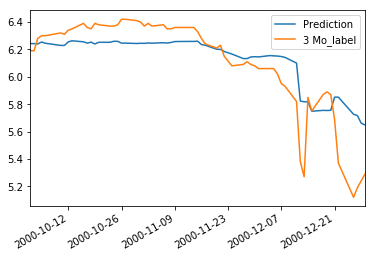

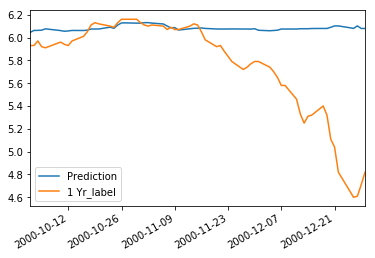

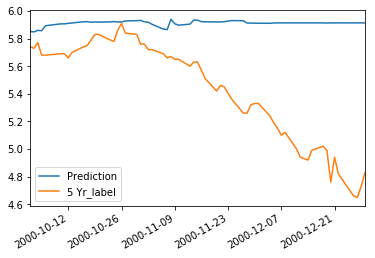

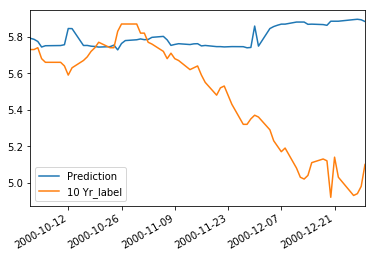

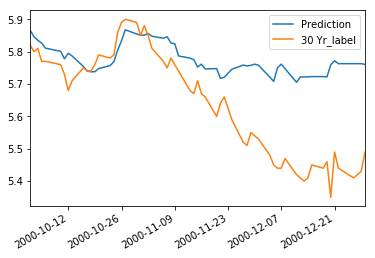

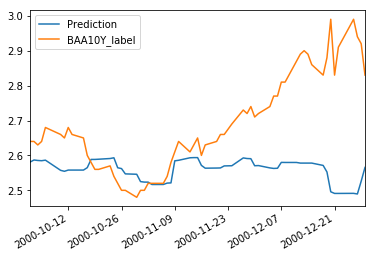

In [14]:
import warnings
warnings.filterwarnings('ignore')

results = []
for interest_to_predict in period_labels:
    rolling_data_df = data_df
    rolling_data_df['mean'] = data_df[interest_to_predict].rolling(window=BUSINESS_DAYS).mean()
    rolling_data_df['std'] = data_df[interest_to_predict].rolling(window=BUSINESS_DAYS).std()
    rolling_train_df = rolling_data_df.loc[TRAIN_START_DATE:VAL_END_DATE]
    rolling_test_df = rolling_data_df.loc[TEST_START_DATE:TEST_END_DATE]
    rolling_train_df = rolling_train_df.dropna()
    rolling_test_df = rolling_test_df.dropna()
    regr = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
    regr.fit(rolling_train_df[features], rolling_train_df[interest_to_predict])
    y_predict = pd.DataFrame(data=regr.predict(rolling_test_df[features]).reshape(-1,1), columns=['Prediction'])
    y_true = rolling_test_df[interest_to_predict]
    y_predict.index = y_true.index
    prediction_df = pd.concat([y_predict, y_true], axis=1)
    prediction_df.plot()
    results.append(mean_squared_error(y_predict, y_true))

results_df = add_column_to_df(results_df, 'Results on test data', results)
print(results)

It can be seen that for all interest rate time series there is a decrease in the interest rate which the predictions 
did not manage to predict correctly.

Furthermore, the spread trend went up at the test time while the prediction did not manage to predict it as well.